In [1]:
import numpy as np
import os
import matplotlib.pyplot as plt
from scipy.sparse import csr_matrix, coo_matrix
from implicit.als import AlternatingLeastSquares
from sklearn.metrics import mean_squared_error


data_dir = 'data/'

ratings_train = np.load(os.path.join(data_dir, 'ratings_train.npy'))
ratings_test = np.load(os.path.join(data_dir, 'ratings_test.npy'))
names_and_genres = np.load(os.path.join(data_dir, 'namesngenre.npy'))


# # Concat the train and test data and then split them again 90% train and 10% test
# ratings = np.concatenate((ratings_train, ratings_test), axis=0)
# np.random.shuffle(ratings)
# split_index = int(0.9 * ratings.shape[0])

# ratings_train = ratings[:split_index]
# ratings_test = ratings[split_index:]

print(ratings_train.shape)
print(ratings_test.shape)
print(names_and_genres.shape)

/home/stathis/miniconda3/envs/AR3K/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


NameError: name 'ratings' is not defined

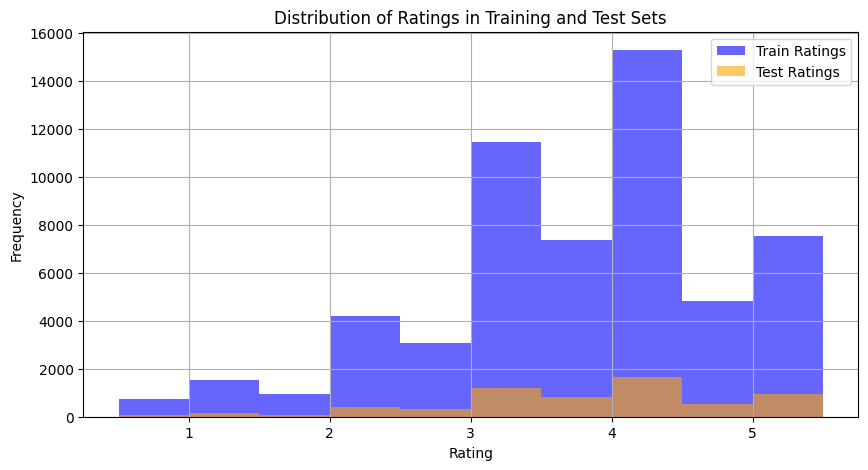

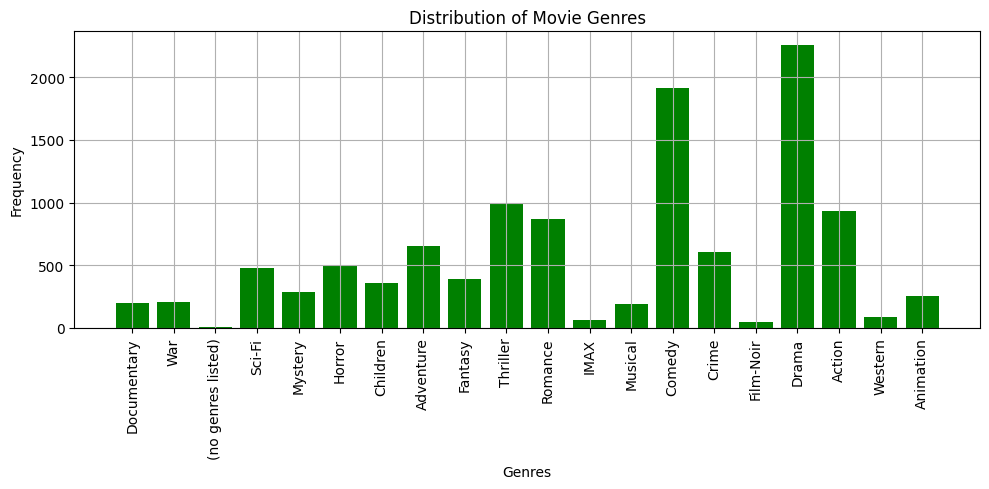

(0.9895735949261527,
 0.9898215814075976,
 {'Documentary': 196,
  'War': 203,
  '(no genres listed)': 8,
  'Sci-Fi': 476,
  'Mystery': 283,
  'Horror': 493,
  'Children': 358,
  'Adventure': 651,
  'Fantasy': 388,
  'Thriller': 991,
  'Romance': 871,
  'IMAX': 66,
  'Musical': 188,
  'Comedy': 1916,
  'Crime': 606,
  'Film-Noir': 50,
  'Drama': 2253,
  'Action': 931,
  'Western': 88,
  'Animation': 257})

In [143]:
# Function to calculate sparsity of the matrix
def calculate_sparsity(matrix):
    total_elements = matrix.size
    non_nan_elements = np.count_nonzero(~np.isnan(matrix))
    sparsity = (total_elements - non_nan_elements) / total_elements
    return sparsity

# Calculate sparsity for train and test data
train_sparsity = calculate_sparsity(ratings_train)
test_sparsity = calculate_sparsity(ratings_test)

# Calculate the distribution of ratings in the training data (excluding NaN values)
train_ratings = ratings_train[~np.isnan(ratings_train)]
test_ratings = ratings_test[~np.isnan(ratings_test)]

# Plot the distribution of ratings
plt.figure(figsize=(10, 5))
plt.hist(train_ratings, bins=np.arange(0.5, 6, 0.5), alpha=0.6, color='blue', label='Train Ratings')
plt.hist(test_ratings, bins=np.arange(0.5, 6, 0.5), alpha=0.6, color='orange', label='Test Ratings')
plt.xlabel('Rating')
plt.ylabel('Frequency')
plt.title('Distribution of Ratings in Training and Test Sets')
plt.legend()
plt.grid(True)
plt.show()

# Generate insights from the genre data
unique_genres = set()
for item in names_and_genres[:, 1]:
    genres = item.split('|')
    unique_genres.update(genres)

# Count the occurrence of each genre
genre_counts = {genre: 0 for genre in unique_genres}
for item in names_and_genres[:, 1]:
    genres = item.split('|')
    for genre in genres:
        genre_counts[genre] += 1

# Plot genre distribution
plt.figure(figsize=(10, 5))
plt.bar(genre_counts.keys(), genre_counts.values(), color='green')
plt.xticks(rotation=90)
plt.xlabel('Genres')
plt.ylabel('Frequency')
plt.title('Distribution of Movie Genres')
plt.grid(True)
plt.tight_layout()
plt.show()

(train_sparsity, test_sparsity, genre_counts)

In [144]:
import numpy as np
from scipy.sparse import coo_matrix
from implicit.als import AlternatingLeastSquares


# Replace NaN with zeros for the ALS model
ratings_train_filled = np.nan_to_num(ratings_train)

# Create a sparse matrix from the training data
train_sparse_matrix = coo_matrix(ratings_train_filled)

# Initialize ALS model
als_model = AlternatingLeastSquares(factors=20, regularization=0.1, iterations=15)

# Train the ALS model
als_model.fit(train_sparse_matrix)

# Compute the full user-item rating matrix
user_factors = als_model.user_factors
item_factors = als_model.item_factors

# Full predicted ratings matrix
predicted_ratings = np.dot(user_factors, item_factors.T)

# Replace known ratings with NaN to focus on predicting the unknown ratings
predicted_ratings[~np.isnan(ratings_train)] = np.nan

# Ensure the predicted ratings matrix has the same shape as the test matrix
assert predicted_ratings.shape == ratings_test.shape

# Now, you can use the `predicted_ratings` to fill in the missing values in the test set
print(predicted_ratings[:5])  # Show first 5 users' predictions


/home/stathis/miniconda3/envs/AR3K/lib/python3.12/site-packages/implicit/utils.py:164: ParameterWarning: Method expects CSR input, and was passed coo_matrix instead. Converting to CSR took 0.00046062469482421875 seconds
  warnings.warn(
100%|██████████| 15/15 [00:00<00:00, 41.33it/s]


AssertionError: 

In [111]:
# Count nan values in the predicted ratings
num_nan_values = np.isnan(predicted_ratings).sum()
num_nan_values

31598

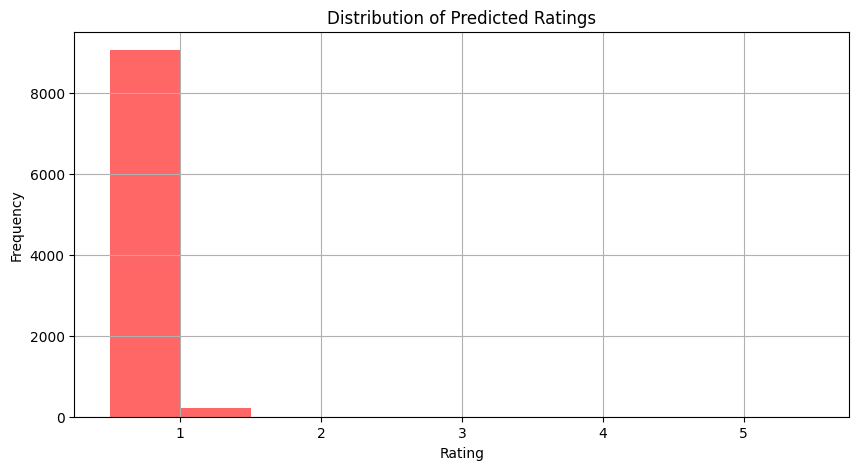

In [112]:
# Plot the distribution of predicted ratings
predicted_ratings = predicted_ratings[~np.isnan(predicted_ratings)]
plt.figure(figsize=(10, 5))
plt.hist(predicted_ratings, bins=np.arange(0.5, 6, 0.5), color='red', alpha=0.6)
plt.xlabel('Rating')
plt.ylabel('Frequency')
plt.title('Distribution of Predicted Ratings')
plt.grid(True)
plt.show()


In [141]:
import numpy as np
from scipy.sparse import coo_matrix
from implicit.als import AlternatingLeastSquares
from sklearn.metrics import mean_squared_error


# Create a mask for known values in the training set
train_mask = ~np.isnan(ratings_train)

# Build a sparse matrix from the known values (ignoring NaN values)
row_indices, col_indices = np.where(train_mask)
data = ratings_train[train_mask]
train_sparse_matrix = coo_matrix((data, (row_indices, col_indices)), shape=ratings_train.shape)

# Initialize ALS model (you can tune the parameters as needed)
als_model = AlternatingLeastSquares(factors=20, regularization=0.05, iterations=300)

# Train the ALS model on the sparse matrix
als_model.fit(train_sparse_matrix)

# Get the user and item factors after training
user_factors = als_model.user_factors
item_factors = als_model.item_factors

# Generate the full predicted ratings matrix using the dot product of user and item factors
predicted_ratings = np.dot(user_factors, item_factors.T)

# Apply min-max scaling to the predicted ratings
min_val, max_val = np.min(predicted_ratings), np.max(predicted_ratings)
scaled_predictions = 0.5 + (predicted_ratings - min_val) * (5 - 0.5) / (max_val - min_val)

# Clip the scaled predictions to ensure they stay within [0.5, 5]
scaled_predictions_clipped = np.clip(scaled_predictions, 0.5, 5)

# Fill in the missing values in the test set (i.e., where test set has NaN values)
filled_test_set = np.copy(ratings_test)
nan_mask = np.isnan(filled_test_set)
filled_test_set[nan_mask] = scaled_predictions_clipped[nan_mask]

# Extract non-NaN values from the test set and corresponding predictions
test_mask = ~np.isnan(ratings_test)
actual_test_ratings = ratings_test[test_mask]
predicted_test_ratings = scaled_predictions_clipped[test_mask]

# Calculate RMSE to compare predicted values with actual values in the test set
rmse = np.sqrt(mean_squared_error(actual_test_ratings, predicted_test_ratings))
print(f"RMSE between predicted and actual test ratings: {rmse}")

# Calculate accuracy (percentage of exact matches)
exact_matches = np.sum(np.isclose(predicted_test_ratings, actual_test_ratings, atol=0.25))  # Allow small tolerance
total_ratings = len(actual_test_ratings)
accuracy = exact_matches / total_ratings * 100

print(f"Accuracy (exact matches): {accuracy:.2f}%")


/home/stathis/miniconda3/envs/AR3K/lib/python3.12/site-packages/implicit/utils.py:164: ParameterWarning: Method expects CSR input, and was passed coo_matrix instead. Converting to CSR took 0.001444101333618164 seconds
  warnings.warn(
100%|██████████| 300/300 [00:05<00:00, 52.88it/s]


IndexError: boolean index did not match indexed array along dimension 0; dimension is 1098 but corresponding boolean dimension is 122

In [134]:
# Take the predictions and round to the nearest 0.5
scaled_predictions_clipped_rounded = np.round(scaled_predictions_clipped * 2) / 2

# Calculate RMSE to compare predicted values with actual values in the test set
rmse = np.sqrt(mean_squared_error(actual_test_ratings, predicted_test_ratings))
rmse_rounded = np.sqrt(mean_squared_error(actual_test_ratings, scaled_predictions_clipped_rounded[test_mask]))

print(f"RMSE before rounding: {rmse}\nRMSE after rounding predictions: {rmse_rounded}")



RMSE before rounding: 1.9489379955816446
RMSE after rounding predictions: 1.9390394639256128


In [135]:
# Print the predicted ratings for the first user against the true ratings in the test set
user_id = 0
user_ratings = ratings_test[user_id]
predicted_user_ratings = scaled_predictions_clipped[user_id]
predicted_user_ratings_rounded = scaled_predictions_clipped_rounded[user_id]

# Print the training ratings for the first user (excluding NaN values)
print("Training Ratings:")
print(ratings_train[user_id][~np.isnan(ratings_train[user_id])])



# Create a mask for known values in the test set
known_mask = ~np.isnan(user_ratings)

# Print the true and predicted ratings for the first user
print("True Ratings:")
print(user_ratings[known_mask])
print("\nPredicted Ratings:")
print(predicted_user_ratings[known_mask])
print("\nPredicted Ratings (Rounded):")
print(predicted_user_ratings_rounded[known_mask])


Training Ratings:
[4. 5. 3. 4. 5. 5. 4. 5. 3. 5. 4. 4. 5. 4. 3. 5. 5. 5. 5. 5. 5. 5. 5. 5.
 4. 3. 5. 4. 3. 5. 3. 5. 5. 5. 4. 4. 5. 5. 5. 5. 5. 5. 4. 5. 5. 4. 3. 5.
 3. 5. 2. 3. 5. 5. 5. 5. 5. 5. 5. 5. 4. 5. 1. 3. 3. 4. 4. 5. 4. 5. 4.]
True Ratings:
[4. 4. 5. 5. 5. 3. 5. 3. 3. 4. 4. 5. 4. 4. 5. 3. 3. 5. 4. 3. 5. 5. 4. 5.
 4. 5. 5. 5. 3. 5. 5. 3. 3. 4. 5. 5. 3. 4. 4. 4. 5. 5. 4. 4. 5. 4. 5. 4.
 5. 2. 5. 5. 5. 4. 4. 5. 4. 4. 4. 5. 5. 4. 5. 5. 5. 5. 5. 5. 5. 5. 5. 4.
 5. 5. 4. 5. 5. 4. 4.]

Predicted Ratings:
[1.7743762 1.9835589 1.6862304 1.7125279 1.7566819 2.2216487 1.801005
 1.9948646 2.0780332 1.9833525 1.8845819 1.9810911 2.1728826 1.9662191
 1.8763771 2.2694962 1.7262186 1.8319625 1.740943  1.7356861 1.696464
 2.0780847 2.0339568 1.9396312 2.1470904 1.9776214 2.013494  1.7465086
 1.8910493 1.7605513 2.2144651 1.6888607 1.7909856 1.9657568 2.2776542
 1.7765944 1.9433283 1.9949435 2.281986  1.9234377 1.6775413 1.7133968
 1.692571  2.1699362 1.8815562 1.7176561 1.9270382 1.8571587 1.99

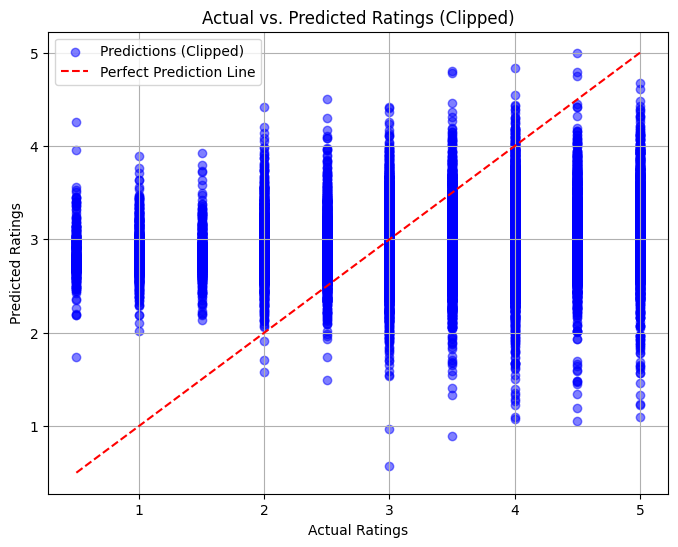

In [115]:
# Clip the predicted ratings to the valid range (0.5 to 5)
predicted_ratings_clipped = np.clip(scaled_predictions_clipped, 0.5, 5)

# Use the clipped values for the comparison
predicted_test_ratings = predicted_ratings_clipped[test_mask]

# Plot again with the clipped predictions
plt.figure(figsize=(8, 6))
plt.scatter(actual_test_ratings, predicted_test_ratings, alpha=0.5, color='blue', label='Predictions (Clipped)')
plt.plot([0.5, 5], [0.5, 5], color='red', linestyle='--', label='Perfect Prediction Line')
plt.xlabel('Actual Ratings')
plt.ylabel('Predicted Ratings')
plt.title('Actual vs. Predicted Ratings (Clipped)')
plt.legend()
plt.grid(True)
plt.show()


### NANs Replaced by 0s

In [116]:
import numpy as np
from scipy.sparse import coo_matrix
from implicit.als import AlternatingLeastSquares
from sklearn.metrics import mean_squared_error

# Load datasets
ratings_train = np.load(os.path.join(data_dir, 'ratings_train.npy'))
ratings_test = np.load(os.path.join(data_dir, 'ratings_test.npy'))

# Replace NaN values in the training set with 0 (indicating absence of a rating)
ratings_train_filled_with_zeros = np.nan_to_num(ratings_train)

# Build a sparse matrix from the training data (with NaNs replaced by 0)
row_indices, col_indices = np.where(ratings_train_filled_with_zeros != 0)
data = ratings_train_filled_with_zeros[row_indices, col_indices]
train_sparse_matrix = coo_matrix((data, (row_indices, col_indices)), shape=ratings_train.shape)

# Initialize ALS model (you can tune the parameters as needed)
als_model = AlternatingLeastSquares(factors=40, regularization=1, iterations=30)

# Train the ALS model on the sparse matrix
als_model.fit(train_sparse_matrix)

# Get the user and item factors after training
user_factors = als_model.user_factors
item_factors = als_model.item_factors

# Generate the full predicted ratings matrix using the dot product of user and item factors
predicted_ratings = np.dot(user_factors, item_factors.T)

# Clip the predicted ratings to the range [0.5, 5]
predicted_ratings_clipped = np.clip(predicted_ratings, 0.5, 5)

# Fill in the missing values in the test set (i.e., where test set has NaN values)
filled_test_set = np.copy(ratings_test)
nan_mask = np.isnan(filled_test_set)
filled_test_set[nan_mask] = predicted_ratings_clipped[nan_mask]

# Extract non-NaN values from the test set and corresponding predictions
test_mask = ~np.isnan(ratings_test)
actual_test_ratings = ratings_test[test_mask]
predicted_test_ratings = predicted_ratings_clipped[test_mask]

# Calculate RMSE to compare predicted values with actual values in the test set
rmse = np.sqrt(mean_squared_error(actual_test_ratings, predicted_test_ratings))
print(f"RMSE between predicted and actual test ratings: {rmse}")

# Calculate accuracy (percentage of exact matches)
exact_matches = np.sum(np.isclose(predicted_test_ratings, actual_test_ratings, atol=0.25))  # Allow small tolerance
total_ratings = len(actual_test_ratings)
accuracy = exact_matches / total_ratings * 100

print(f"Accuracy (exact matches): {accuracy:.2f}%")


/home/stathis/miniconda3/envs/AR3K/lib/python3.12/site-packages/implicit/utils.py:164: ParameterWarning: Method expects CSR input, and was passed coo_matrix instead. Converting to CSR took 0.0002608299255371094 seconds
  warnings.warn(
100%|██████████| 30/30 [00:00<00:00, 55.76it/s]


RMSE between predicted and actual test ratings: 3.1786412380495976
Accuracy (exact matches): 1.37%


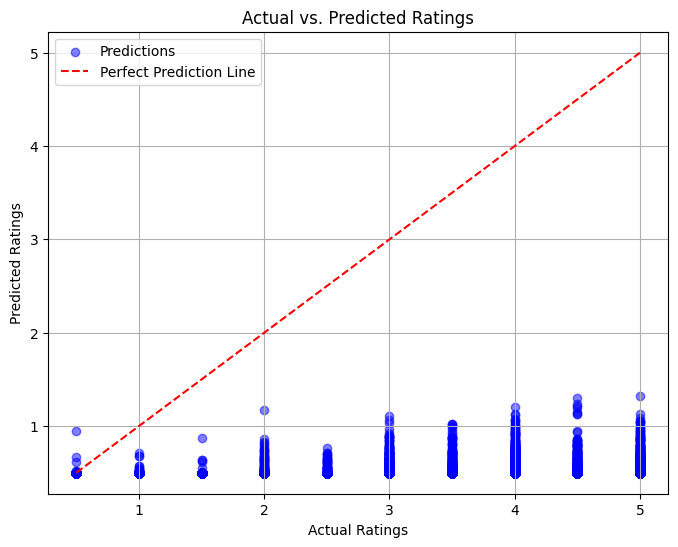

In [117]:
import matplotlib.pyplot as plt
import numpy as np
from sklearn.metrics import mean_squared_error

# Assuming you've already calculated `actual_test_ratings` and `predicted_test_ratings`

# Scatter plot of actual vs predicted ratings
plt.figure(figsize=(8, 6))
plt.scatter(actual_test_ratings, predicted_test_ratings, alpha=0.5, color='blue', label='Predictions')

# Plot the line of equality (y = x) to compare perfect predictions
plt.plot([0.5, 5], [0.5, 5], color='red', linestyle='--', label='Perfect Prediction Line')

# Add labels and title
plt.xlabel('Actual Ratings')
plt.ylabel('Predicted Ratings')
plt.title('Actual vs. Predicted Ratings')
plt.legend()
plt.grid(True)
plt.show()
